In [29]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO

In [30]:
cs = dict()

db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

toload = [ 
    dict(name="base", id="eb1-1D-threshold", guard_replace = False, unnormalise = True),

]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])
    cs[case["name"]].ds.load()

Skipping unnormalisation


# Convergence

In [31]:
cs.keys()

dict_keys(['base'])

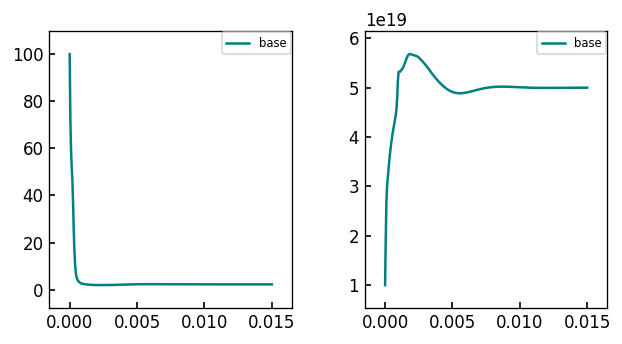

In [32]:
fig, axes = plt.subplots(1,2, figsize = (6,3), dpi = 120)

for case in cs.keys():
    ds = cs[case].ds
    t = ds["t"] - ds["t"].isel(t=0)
    axes[0].plot(t, ds["Te"].isel(pos = -3), label = case)
    axes[1].plot(t, ds["Ne"].isel(pos = 2), label = case)
    
for ax in axes:
    ax.legend(fontsize = "x-small")
fig.subplots_adjust(wspace=0.3)

In [34]:
bal.print_balances2()

/home/mike/work/sdtools/hermes3/balance1d.py:56: SyntaxWarning: invalid escape sequence '\+'
  sheath_flux_candidates = [var for var in ds.data_vars if re.search("S.*\+_sheath", var)]


ValueError: Dimensions {'t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'pos': 400})

In [ ]:
bal = Balance1D(cs["base"].ds.isel(t=-1), use_sheath_diagnostic = True)
bal.get_terms()
bal.get_tallies()
# bal.print_balances()
# bal.plot_heat_balance()


Warning! RAr not found, results may be incorrect


ValueError: Dimensions {'t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'pos': 400})

In [40]:
bal.hbal

{'Ed+_src': np.float64(156.63951518367577),
 'Ee_src': np.float64(156.63951518367577),
 'Ed_src': np.float64(0.0),
 'Rd+_ex': np.float64(-212.13398387261373),
 'Rd+_rec': np.float64(-0.043704973260034516),
 'RAr': array(0.),
 'Ed_target_recycle': np.float64(36.505086215798),
 'Ee_sheath': np.float64(-81.89496070253865),
 'Ed+_sheath': np.float64(-77.27514850505139)}

In [41]:
bal.print_balances()


Particle flows [s^-1]
----------------------
Sd+_src: 0.000e+00
Sd_src: 6.510e+25
Sd+_feedback: 2.102e+21
Sd+_iz: 6.525e+25
Sd+_rec: -1.471e+23
Sd_target_recycle: 6.510e+25
Sd+_sheath: -6.510e+25
----------------------
Derived quantities
----------------------
sources_sum: 6.510e+25
sheath_sum: 0.000e+00
recycle_frac: 1.000e+00
----------------------
Diagnostic output
----------------------
(sources + recycled flow) / sources: 3.229e-05


Heat flows [MW]
----------------------
Ed+_src: 1.566e+02
Ee_src: 1.566e+02
Ed_src: 0.000e+00
Rd+_ex: -2.121e+02
Rd+_rec: -4.370e-02
RAr: 0.000e+00
Ed_target_recycle: 3.651e+01
Ee_sheath: -8.189e+01
Ed+_sheath: -7.728e+01
----------------------
Derived quantities
----------------------
sources_sum: 3.133e+02
R_hydr_sum: -2.122e+02
R_imp_sum: 0.000e+00
R_sum: -2.122e+02
R_and_sources_sum: 1.011e+02
sheath_sum: -1.592e+02
power_in: 3.133e+02
power_out: -3.713e+02
----------------------
Diagnostic output
----------------------
Error: (R + Src + Sheath) 

In [27]:
ds = cs["base"].ds.isel(t=-1, pos = slice(2,-2))
(ds["Pd+_src"]*ds["dv"]).sum().values

array(6379049.69121944)

In [21]:
(bal.dom["Pe_src"] * bal.dom["dv"]).sum().values

array(2.39569517e-16)

SOME OF THESE ARE INCORRECT
(401,)


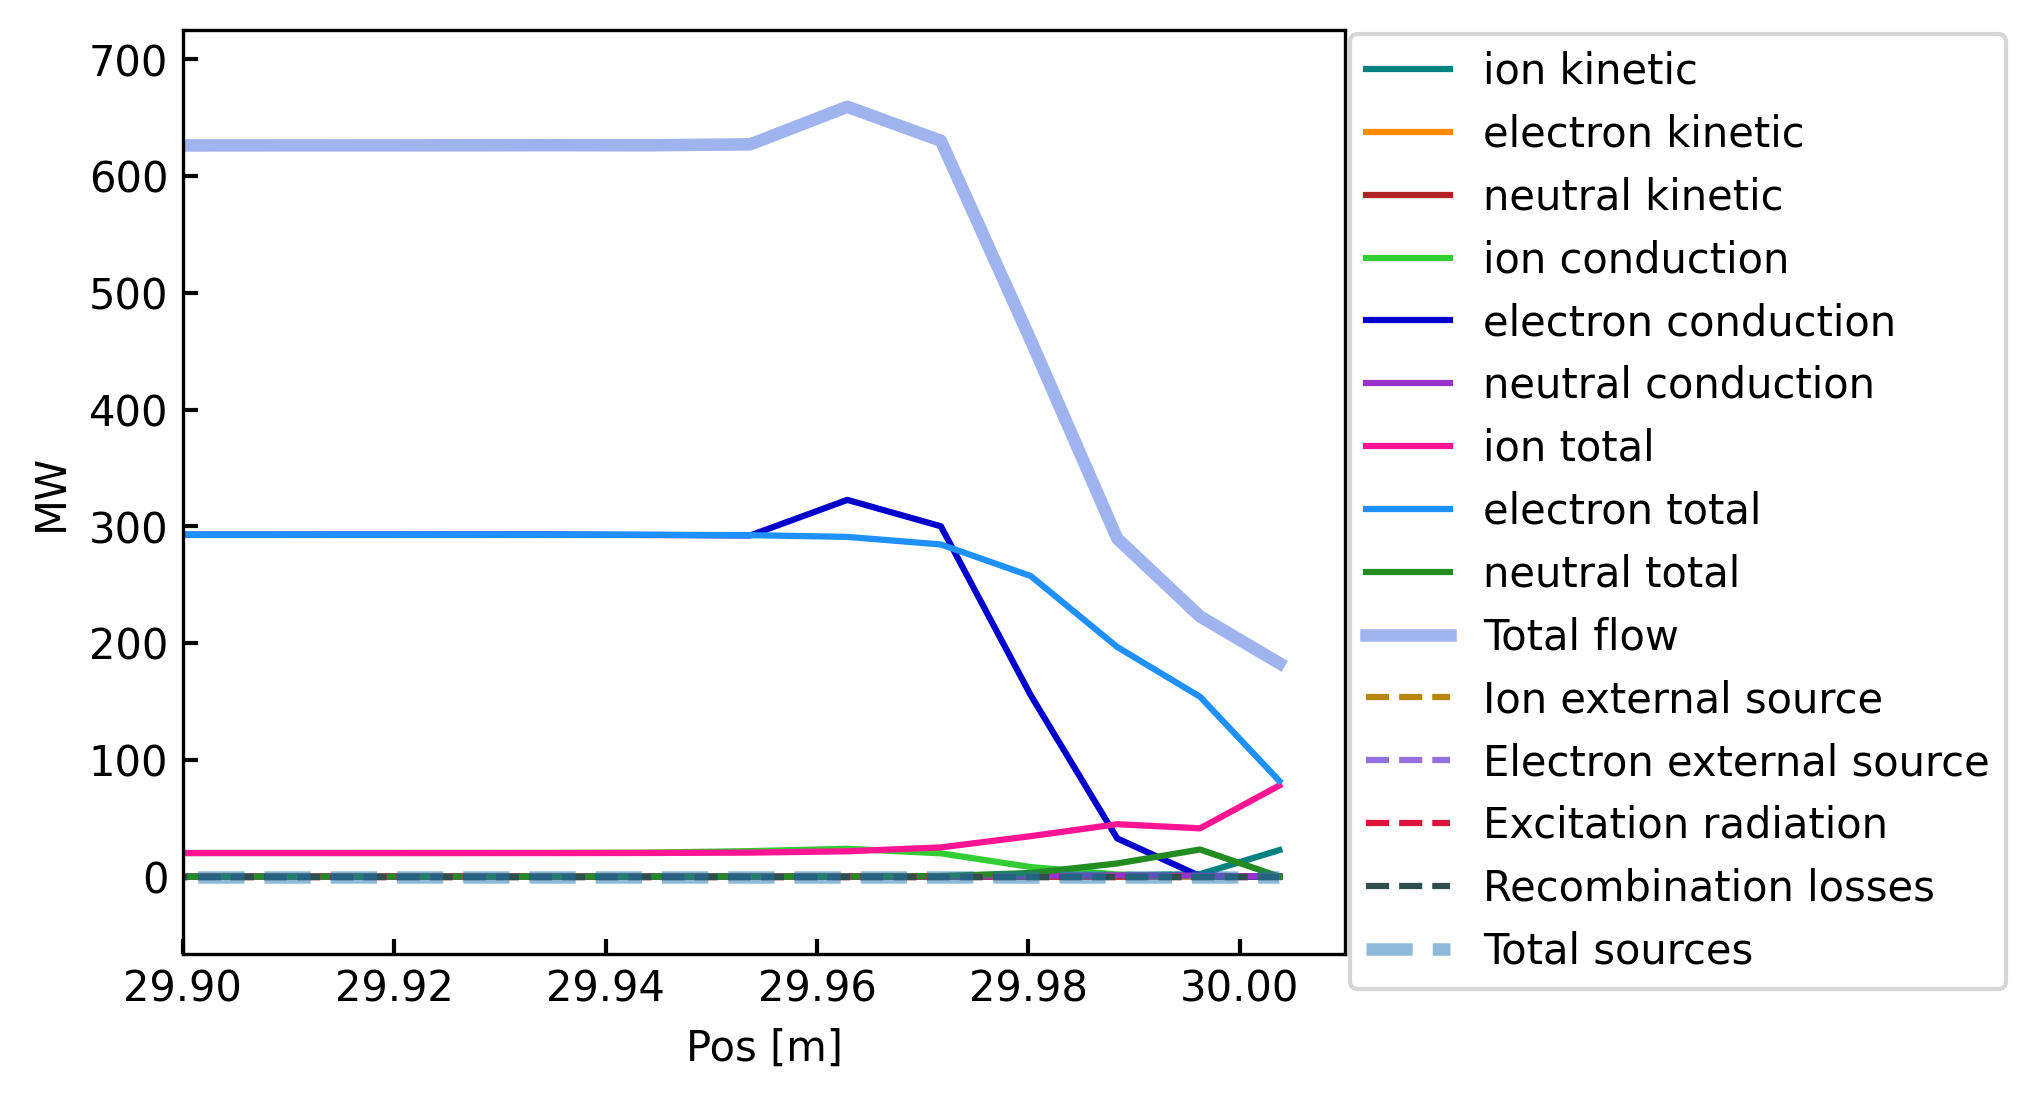

In [8]:
bal.plot_flux_balance2(xlims = (29.9,30.01))

In [10]:
bal.print_balances()


Particle flows [s^-1]
----------------------
Sd+_src: 0.000e+00
Sd_src: 6.510e+25
Sd+_feedback: 2.102e+21
Sd+_iz: 6.525e+25
Sd+_rec: -1.471e+23
Sd_target_recycle: 6.510e+25
Sd+_sheath: -6.510e+25
----------------------
Derived quantities
----------------------
sources_sum: 6.510e+25
sheath_sum: 0.000e+00
recycle_frac: 1.000e+00
----------------------
Diagnostic output
----------------------
Imbalance: sources + net sheath flux: 6.510e+25 [s^-1]


Heat flows [MW]
----------------------
Ed+_src: 1.566e+02
Ee_src: 1.566e+02
Ed_src: 0.000e+00
Rd+_ex: -2.121e+02
Rd+_rec: -4.370e-02
RAr: 0.000e+00
Ed_target_recycle: 3.651e+01
Ee_sheath: -8.189e+01
Ed+_sheath: -7.728e+01
----------------------
Derived quantities
----------------------
sources_sum: 3.133e+02
R_hydr_sum: -2.122e+02
R_imp_sum: 0.000e+00
R_sum: -2.122e+02
R_and_sources_sum: 1.011e+02
sheath_sum: -1.592e+02
----------------------
Diagnostic output
----------------------
Error: (R + Src + Sheath) / Src: -18.54%


<unknown>:56: SyntaxWarning: invalid escape sequence '\+'
<unknown>:56: SyntaxWarning: invalid escape sequence '\+'
